In [1]:
from operator import index

import pandas as pd
import numpy as np
from pandas.core.common import random_state
from pandas.core.interchange.from_dataframe import categorical_column_to_series
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tensorflow.python.ops.gen_dataset_ops import model_dataset
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

c:\PYTHON\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chunk_size = 100000

In [3]:
# Initialize variables for analysis
total_rows = 0
column_sums = None
column_squared_sums = None

In [4]:
# Step 3: Read the data in chunks
def read_csv_in_chunks(file_path, chunk_size):
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        yield chunk

In [5]:
# Step 4: Sample 20% of observation
labels = pd.read_csv('train_labels.csv')
sample_labels = labels.sample(frac=0.2, random_state=42)

In [6]:
# Read data
sampled_data = []
for chunk in read_csv_in_chunks('train_data.csv', chunk_size):
    merged_chunk = pd.merge(chunk, sample_labels, on='customer_ID', how='inner')
    sampled_data.append(merged_chunk)
    
# Combine all chunks into a single dataframe
development_sample = pd.concat(sampled_data, ignore_index=True)

# Save the development sample
development_sample.to_csv('development_sample.csv', index=False)

c:\PYTHON\.venv\lib\site-packages\pandas\core\indexes\base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [7]:
# load development_sample
data = []
for chunk in read_csv_in_chunks('development_sample.csv', chunk_size):
    data.append(chunk)

    

In [8]:
df = pd.concat(data, ignore_index=True)
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,NaN,NaN,0.008263,0.006609,0.007370,NaN,0.007171,0.005120,0.007513,0
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,NaN,NaN,0.001986,0.004050,0.000796,NaN,0.001802,0.002364,0.003987,0
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,NaN,NaN,0.009515,0.008757,0.009219,NaN,0.003134,0.001686,0.001265,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,NaN,NaN,0.002524,0.007841,0.007421,NaN,0.000728,0.003591,0.007998,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,NaN,NaN,0.003823,0.009599,0.006957,NaN,0.008746,0.007101,0.006658,0


In [9]:
def calculate_default_rate(data):
    # Initialize a DataFrame to store the results
    default_rates = pd.DataFrame(columns=["Category", "#Observations", "Default rate"])
    
    # Get the total number of unique customer IDs
    total_customers = len(data["customer_ID"].unique())
    
    # Calculate default rate for all applicants
    default_rate_all = data["target"].mean()
    default_rates.loc[0] = ["All applicants", total_customers, default_rate_all]
    
    # Calculate default rate for each category of historic data length
    for months in range(13, 0, -1):  # Iterate from 13 months to 1 month
        category_customers = data.groupby("customer_ID").size() == months  # Check if each customer has data for the specific number of months
        category_observations = category_customers.sum()  # Get the number of customers in this category
        category_data = data[data["customer_ID"].isin(category_customers[category_customers].index)]  # Filter data for the specific category
        default_rate_category = category_data["target"].mean()  # Calculate default rate for this category
        default_rates.loc[len(default_rates)] = [f"Applications with {months} months of historic data", category_observations, default_rate_category]
    
    return default_rates

# Call the function with your development_sample dataset
default_rates_data = calculate_default_rate(development_sample)
# Display the results
print(default_rates_data)

                                        Category  #Observations  Default rate
0                                 All applicants          91783      0.246498
1   Applications with 13 months of historic data          77348      0.229405
2   Applications with 12 months of historic data           2115      0.378723
3   Applications with 11 months of historic data           1159      0.440897
4   Applications with 10 months of historic data           1329      0.465764
5    Applications with 9 months of historic data           1278      0.435837
6    Applications with 8 months of historic data           1169      0.450813
7    Applications with 7 months of historic data           1046      0.414914
8    Applications with 6 months of historic data           1109      0.412985
9    Applications with 5 months of historic data            933      0.394427
10   Applications with 4 months of historic data            938      0.430704
11   Applications with 3 months of historic data           1158 

In [10]:
development_sample = pd.read_csv('development_sample.csv')
development_sample.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,NaN,NaN,0.008263,0.006609,0.007370,NaN,0.007171,0.005120,0.007513,0
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,NaN,NaN,0.001986,0.004050,0.000796,NaN,0.001802,0.002364,0.003987,0
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,NaN,NaN,0.009515,0.008757,0.009219,NaN,0.003134,0.001686,0.001265,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,NaN,NaN,0.002524,0.007841,0.007421,NaN,0.000728,0.003591,0.007998,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,NaN,NaN,0.003823,0.009599,0.006957,NaN,0.008746,0.007101,0.006658,0


In [11]:
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [12]:
# Step 5: One-hot encoding for categorical variables
# List of known categorical columns
# List of categorical columns

# Function to read and process data in chunks
def process_chunks(file_path, chunk_size=100000):
    encoded_chunks = []
    
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert all specified columns to strings
        for col in categorical_columns:
            chunk[col] = chunk[col].astype(str)
        
        # Perform one-hot encoding
        encoded_chunk = pd.get_dummies(chunk, columns=categorical_columns)
        
        # Ensure the encoded columns are of type int (0 or 1)
        for col in encoded_chunk.columns:
            if col.startswith(tuple(categorical_columns)):
                encoded_chunk[col] = encoded_chunk[col].astype(int)
        
        encoded_chunks.append(encoded_chunk)
        
        print(f"Processed chunk of size {len(chunk)}")
    
    return pd.concat(encoded_chunks, ignore_index=True)

# Process the file
df_encoded = process_chunks('development_sample.csv')

print("One-hot encoding completed.")
print(f"Shape of encoded DataFrame: {df_encoded.shape}")

# Display the first few rows of the encoded DataFrame
print(df_encoded.head())

# Check the data types of the encoded columns
print(df_encoded.dtypes)

Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 7082
One-hot encoding completed.
Shape of encoded DataFrame: (1107082, 235)
                                         customer_ID         S_2       P_2  \
0  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-03-11  0.374606   
1  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-04-22  0.414269   
2  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-05-12  0.413310   
3  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-06-10  0.328983   
4  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-07-19  0.496989   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.03351

In [13]:
df_encoded.to_csv('train_encoded_data.csv', index=False)

c:\PYTHON\.venv\lib\site-packages\pandas\core\indexes\base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


***USE THE BELOW CODE FOR QUESTION 6~***

In [14]:
# Step 6: Feature Engineering
df = pd.read_csv('train_encoded_data.csv')
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,0,1,0,0,0,0,0,0,0,1
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,0,1,0,0,0,0,0,0,0,1
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,0,1,0,0,1,0,0,0,0,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,0,1,0,0,1,0,0,0,0,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,0,1,0,0,1,0,0,0,0,0


In [15]:
features = df.drop([ 'S_2' ], axis=1).columns.to_list()
cat_col = [i for i in features if i.startswith('B_30')or i.startswith('B_38') or i.startswith('D_114') or
i.startswith('D_116')or i.startswith('D_117') or i.startswith('D_120') or i.startswith('D_126')
or i.startswith('D_63')or i.startswith('D_64')or i.startswith('D_66') or i.startswith('D_68')]
ind_col = ['customer_ID', 'target']
num_col = [col for col in features if col not in cat_col and col not in ind_col]

In [16]:
import pandas as pd

# Assuming df is already loaded and contains the necessary columns
# Ensure 'S_2' column is in datetime format
df['S_2'] = pd.to_datetime(df['S_2'])

# Define the numerical columns
num_col = [col for col in df.columns if col not in ['customer_ID', 'S_2', 'target']]

def calculate_numerical_statistics(df, time_period):
    last_date = df['S_2'].max()
    time_period_ago = last_date - pd.DateOffset(months=time_period)

    data_last_time_period = df[(df['S_2'] > time_period_ago) & (df['S_2'] <= last_date)]

    average_spend_last_time_period = data_last_time_period.groupby('customer_ID')[num_col].agg(['mean', 'min', 'max', 'sum'])
    average_spend_last_time_period.columns = [f'{col}_{agg}_{time_period}' for col, agg in average_spend_last_time_period.columns]

    return average_spend_last_time_period

# Calculate statistics for different time periods
average_spend_3_months = calculate_numerical_statistics(df, 3)
average_spend_6_months = calculate_numerical_statistics(df, 6)
average_spend_9_months = calculate_numerical_statistics(df, 9)
average_spend_12_months = calculate_numerical_statistics(df, 12)

final_numerical_df = pd.merge(average_spend_3_months, average_spend_6_months, on='customer_ID', how='inner')
final_numerical_df = pd.merge(final_numerical_df, average_spend_9_months, on='customer_ID', how='inner')
df_num_agg = pd.merge(final_numerical_df, average_spend_12_months, on='customer_ID', how='inner')

print(df_num_agg.head())

                                                    P_2_mean_3  P_2_min_3  \
customer_ID                                                                 
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f523...    0.447801   0.414444   
000445609ff2a39d2dd02484899affa5696210a95f6869f...    0.976846   0.974383   
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff...    0.638958   0.634894   
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab7040...    0.973429   0.963991   
00050d84c6d26e26cd2b18c3eed83d3130c270e2361470f...    0.993352   0.968914   

                                                    P_2_max_3  P_2_sum_3  \
customer_ID                                                                
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f523...   0.477116   1.343404   
000445609ff2a39d2dd02484899affa5696210a95f6869f...   0.978897   2.930539   
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff...   0.642295   1.916874   
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab7040...   0.980221   2.920287   
0005

In [17]:
df_num_agg.to_csv('df_num_agg.csv', index=True)

c:\PYTHON\.venv\lib\site-packages\pandas\core\indexes\base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [18]:
df_num_agg = pd.read_csv('df_num_agg.csv')
df_num_agg.columns


Index(['customer_ID', 'P_2_mean_3', 'P_2_min_3', 'P_2_max_3', 'P_2_sum_3',
       'D_39_mean_3', 'D_39_min_3', 'D_39_max_3', 'D_39_sum_3', 'B_1_mean_3',
       ...
       'D_68_5.0_max_12', 'D_68_5.0_sum_12', 'D_68_6.0_mean_12',
       'D_68_6.0_min_12', 'D_68_6.0_max_12', 'D_68_6.0_sum_12',
       'D_68_nan_mean_12', 'D_68_nan_min_12', 'D_68_nan_max_12',
       'D_68_nan_sum_12'],
      dtype='object', length=3713)

In [19]:
# categorical data
df[['customer_ID','S_2'] + cat_col].to_csv('df_categorical.csv')

In [20]:
# 
def calculate_categorical_statistics(df, time_period):
    last_date = df['S_2'].max()
    time_period_ago = last_date - pd.DateOffset(months=time_period)

    data_last_time_period = df[(df['S_2'] > time_period_ago) & (df['S_2'] <= last_date)]

    response_rate = data_last_time_period.groupby('customer_ID')[cat_col].agg(['mean', 'max'])
    response_rate.columns = [f'{col}_{agg}_{time_period}' for col, agg in response_rate.columns]
    return response_rate

df_cat_six = calculate_categorical_statistics(df, 6)
df_cat_twelve = calculate_categorical_statistics(df, 12)

df_cat_agg = pd.merge(df_cat_six, df_cat_twelve, on='customer_ID', how='inner')

print(df_cat_agg)
print(df_cat_agg.shape)

                                                    B_30_0.0_mean_6  \
customer_ID                                                           
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f523...         0.500000   
000445609ff2a39d2dd02484899affa5696210a95f6869f...         1.000000   
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff...         0.833333   
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab7040...         1.000000   
00050d84c6d26e26cd2b18c3eed83d3130c270e2361470f...         1.000000   
...                                                             ...   
fffe2bc02423407e33a607660caeed076d713d8a5ad3232...         0.166667   
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd...         0.333333   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...         1.000000   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...         1.000000   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...         1.000000   

                                                    B_30_0.0_max_6  \
custom

In [21]:
df_cat_agg.to_csv('df_cat_agg.csv', index=True)

In [22]:
# Create a DataFrame to store the final feature-engineered data
df_feature_engineered_agg = df_num_agg.merge(df_cat_agg, on='customer_ID', how='inner')
df_feature_engineered_agg.head()

,customer_ID,P_2_mean_3,P_2_min_3,P_2_max_3,P_2_sum_3,D_39_mean_3,D_39_min_3,D_39_max_3,D_39_sum_3,B_1_mean_3,...,D_68_3.0_mean_12_y,D_68_3.0_max_12_y,D_68_4.0_mean_12_y,D_68_4.0_max_12_y,D_68_5.0_mean_12_y,D_68_5.0_max_12_y,D_68_6.0_mean_12_y,D_68_6.0_max_12_y,D_68_nan_mean_12_y,D_68_nan_max_12_y
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.447801,0.414444,0.477116,1.343404,0.014288,0.000467,0.035885,0.042865,0.069795,...,0.333333,1,0.0,0,0.000000,0,0.000000,0,0.083333,1
1,000445609ff2a39d2dd02484899affa5696210a95f6869...,0.976846,0.974383,0.978897,2.930539,0.002024,0.001221,0.002629,0.006072,0.008831,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0
2,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0.638958,0.634894,0.642295,1.916874,0.574667,0.415254,0.685210,1.724002,0.431032,...,0.000000,0,0.0,0,1.000000,1,0.000000,0,0.000000,0
3,0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704...,0.973429,0.963991,0.980221,2.920287,0.268469,0.009431,0.470704,0.805407,0.023506,...,0.000000,0,0.0,0,0.583333,1,0.416667,1,0.000000,0
4,00050d84c6d26e26cd2b18c3eed83d3130c270e2361470...,0.993352,0.968914,1.006598,2.980056,0.092158,0.005624,0.150871,0.276473,0.040335,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0


In [37]:
df_feature_engineered_agg.to_csv('df_feature_engineered_agg.csv', index=True)

c:\PYTHON\.venv\lib\site-packages\pandas\core\indexes\base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [23]:
df_feature_engineered_agg.columns

Index(['customer_ID', 'P_2_mean_3', 'P_2_min_3', 'P_2_max_3', 'P_2_sum_3',
       'D_39_mean_3', 'D_39_min_3', 'D_39_max_3', 'D_39_sum_3', 'B_1_mean_3',
       ...
       'D_68_3.0_mean_12_y', 'D_68_3.0_max_12_y', 'D_68_4.0_mean_12_y',
       'D_68_4.0_max_12_y', 'D_68_5.0_mean_12_y', 'D_68_5.0_max_12_y',
       'D_68_6.0_mean_12_y', 'D_68_6.0_max_12_y', 'D_68_nan_mean_12_y',
       'D_68_nan_max_12_y'],
      dtype='object', length=3933)

In [24]:
df = pd.read_csv('df_feature_engineered_agg.csv', index_col=0)
# df = df_feature_engineered_agg
df.head()

,customer_ID,P_2_mean_3,P_2_min_3,P_2_max_3,P_2_sum_3,D_39_mean_3,D_39_min_3,D_39_max_3,D_39_sum_3,B_1_mean_3,...,D_68_3.0_mean_12_y,D_68_3.0_max_12_y,D_68_4.0_mean_12_y,D_68_4.0_max_12_y,D_68_5.0_mean_12_y,D_68_5.0_max_12_y,D_68_6.0_mean_12_y,D_68_6.0_max_12_y,D_68_nan_mean_12_y,D_68_nan_max_12_y
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.447801,0.414444,0.477116,1.343404,0.014288,0.000467,0.035885,0.042865,0.069795,...,0.333333,1,0.0,0,0.000000,0,0.000000,0,0.083333,1
1,000445609ff2a39d2dd02484899affa5696210a95f6869...,0.976846,0.974383,0.978897,2.930539,0.002024,0.001221,0.002629,0.006072,0.008831,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0
2,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0.638958,0.634894,0.642295,1.916874,0.574667,0.415254,0.685210,1.724002,0.431032,...,0.000000,0,0.0,0,1.000000,1,0.000000,0,0.000000,0
3,0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704...,0.973429,0.963991,0.980221,2.920287,0.268469,0.009431,0.470704,0.805407,0.023506,...,0.000000,0,0.0,0,0.583333,1,0.416667,1,0.000000,0
4,00050d84c6d26e26cd2b18c3eed83d3130c270e2361470...,0.993352,0.968914,1.006598,2.980056,0.092158,0.005624,0.150871,0.276473,0.040335,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0


In [25]:
label = pd.read_csv('train_labels.csv')
df_ = pd.merge(df, label, on='customer_ID', how='inner')

In [26]:
# Step 7; Train-test split
# Use a random seed of 42 for the split.
# Split the data into features and target
X = df_.drop(columns=['customer_ID', 'target'])
y = df_['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



In [27]:
# save train and test data as csv
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test1.to_csv('X_test1.csv', index=False)
y_test1.to_csv('y_test1.csv', index=False)
X_test2.to_csv('X_test2.csv', index=False)
y_test2.to_csv('y_test2.csv', index=False)

c:\PYTHON\.venv\lib\site-packages\pandas\core\indexes\base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [28]:
# Step 8: Calculate feature importance using XGBoost

# Load the training data
# X_train = pd.read_csv('data/X_train.csv')
# y_train = pd.read_csv('data/y_train.csv')

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier()

# Fit the model
xgb_model.fit(X_train, y_train)

# # Plot the feature importance
# plot_importance(xgb_model)

# Save the feature importance
feature_importance = xgb_model.feature_importances_
np.save('feature_importance.npy', feature_importance)

# Display the feature importance
print("Feature importance:")
print(feature_importance)

Feature importance:
[0.17870915 0.01835535 0.00311878 ... 0.         0.         0.        ]


In [29]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [30]:
feature_importance_df.to_csv('feature_importance.csv', index=False)

In [31]:
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.005]
important_features

,Feature,Importance
0,P_2_mean_3,0.178709
16,R_1_mean_3,0.018654
1,P_2_min_3,0.018355
9,B_1_min_3,0.013687
8,B_1_mean_3,0.011424
3003,B_18_sum_12,0.007714
13,B_2_min_3,0.006070
125,B_11_min_3,0.005633


In [32]:
# Run XGB applying parameters 300 trees, 0.5 as learning rate, maximum depth of trees is 4, uses 50% of observation to build each tree, uses 50% of features to build each tree, and assigns a weight of 5 to default observations. 
# Save the model as 'xgb_model_important_features'
# Initialize the XGBClassifier
xgb_model_important_features = xgb.XGBClassifier(n_estimators=300, learning_rate=0.5, max_depth=4, subsample=0.5, colsample_bytree=0.5, scale_pos_weight=5, random_state=71)

# Fit the model
xgb_model_important_features.fit(X_train, y_train)

# Calculate the feature importance
feature_importance_parameter_model = xgb_model_important_features.feature_importances_



In [33]:
# Save the feature importance
feature_importance_parameter_model_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_parameter_model
})
feature_importance_parameter_model_df = feature_importance_parameter_model_df.sort_values(by='Importance', ascending=False)

feature_importance_parameter_model_df.to_csv('feature_importance_parameter_model_initial.csv', index=False)
feature_importance_parameter_model_df = feature_importance_parameter_model_df[feature_importance_parameter_model_df['Importance'] > 0.005]

feature_importance_parameter_model_df.to_csv('feature_importance_parameter_model.csv', index=False)

feature_importance_parameter_model_df

,Feature,Importance
0,P_2_mean_3,0.056932
1,P_2_min_3,0.027526
1147,B_18_sum_6,0.009630
125,B_11_min_3,0.007905
1872,R_1_mean_9,0.007239
16,R_1_mean_3,0.006003
958,B_3_max_6,0.005412
929,P_2_min_6,0.005147


In [34]:
feature_importance_concat_df = pd.concat([feature_importance_parameter_model_df, important_features])
# drop duplicated rows
feature_importance_concat_df = feature_importance_concat_df.drop_duplicates(subset='Feature', keep='first')
feature_importance_concat_df


,Feature,Importance
0,P_2_mean_3,0.056932
1,P_2_min_3,0.027526
1147,B_18_sum_6,0.009630
125,B_11_min_3,0.007905
1872,R_1_mean_9,0.007239
16,R_1_mean_3,0.006003
958,B_3_max_6,0.005412
929,P_2_min_6,0.005147
9,B_1_min_3,0.013687
8,B_1_mean_3,0.011424


In [35]:
feature_importance_concat_df.to_csv('feature_importance_concat.csv', index=False)

         Feature  Importance    Model
0     P_2_mean_3    0.178709  Model 1
0     P_2_mean_3    0.056932  Model 2
1      P_2_min_3    0.027526  Model 2
1     R_1_mean_3    0.018654  Model 1
2      P_2_min_3    0.018355  Model 1
3      B_1_min_3    0.013687  Model 1
4     B_1_mean_3    0.011424  Model 1
2     B_18_sum_6    0.009630  Model 2
3     B_11_min_3    0.007905  Model 2
5    B_18_sum_12    0.007714  Model 1
4     R_1_mean_9    0.007239  Model 2
6      B_2_min_3    0.006070  Model 1
5     R_1_mean_3    0.006003  Model 2
7     B_11_min_3    0.005633  Model 1
6      B_3_max_6    0.005412  Model 2
7      P_2_min_6    0.005147  Model 2
8    D_49_mean_9    0.004956  Model 2
9    D_62_mean_3    0.004655  Model 2
10     B_1_max_3    0.004623  Model 2
8    D_45_max_12    0.004499  Model 1
11   D_42_mean_9    0.004459  Model 2
9      B_9_max_3    0.004314  Model 1
12    B_1_mean_3    0.003830  Model 2
13   D_56_mean_9    0.003737  Model 2
10   D_42_max_12    0.003737  Model 1
14   D_42_ma

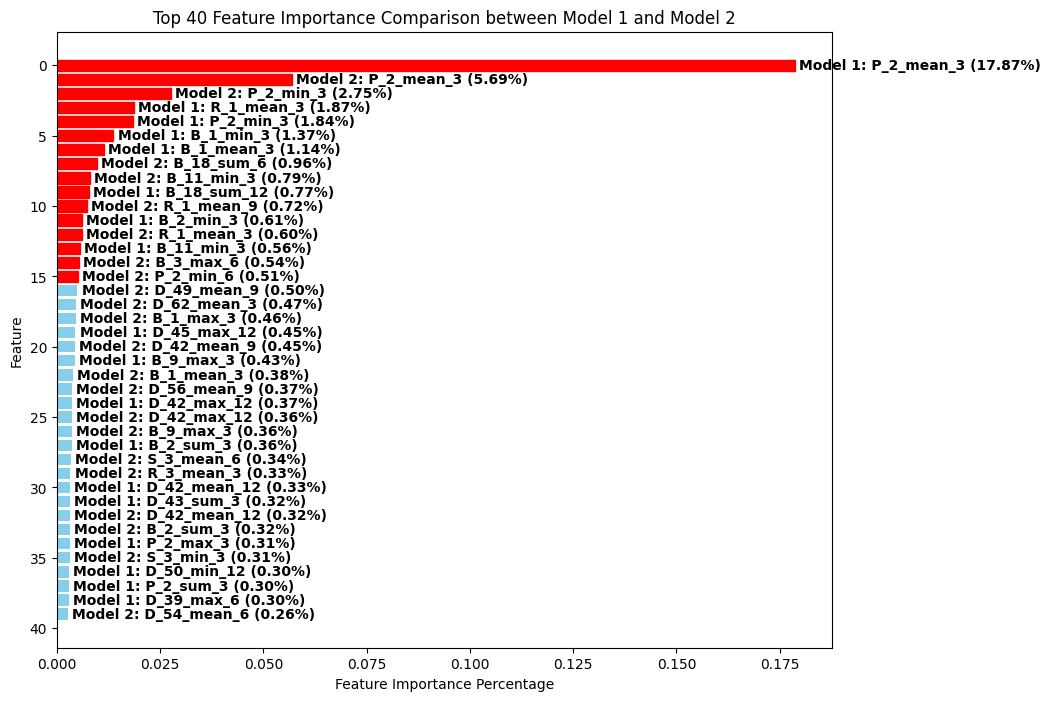

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load feature importance from the first model
feature_importance_initial_df1 = pd.read_csv('feature_importance.csv')
feature_importance_initial_df1['Model'] = 'Model 1'

# Load feature importance from the second model
feature_importance_initial_df2 = pd.read_csv('feature_importance_parameter_model_initial.csv')
feature_importance_initial_df2['Model'] = 'Model 2'

# Concatenate both DataFrames
combined_feature_importance_initial = pd.concat([feature_importance_initial_df1, feature_importance_initial_df2])

# Sort the combined DataFrame by importance values in descending order
combined_feature_importance_initial.sort_values(by='Importance', ascending=False, inplace=True)

# Filter the top 30 features
top_30_features = combined_feature_importance_initial.head(40)
print(top_30_features)
# Plotting
plt.figure(figsize=(10, 8))

# Plot horizontal bars
bars = plt.barh(range(len(top_30_features)), top_30_features['Importance'], color='skyblue')

# Add labels for model name and percentage
for i, bar in enumerate(bars):
    feature = top_30_features.iloc[i]['Feature']
    importance = top_30_features.iloc[i]['Importance']
    model = top_30_features.iloc[i]['Model']
    if importance > 0.005:
        bar.set_color('red')
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{model}: {feature} ({importance:.2%})', va='center', ha='left', fontsize=10, color='black', weight='bold')

# Add labels and title
plt.xlabel('Feature Importance Percentage')
plt.ylabel('Feature')
plt.title('Top 40 Feature Importance Comparison between Model 1 and Model 2')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top

# Show plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Sort the combined DataFrame by importance values in descending order
feature_importance_concat_df.sort_values(by='Importance', ascending=False, inplace=True)

# Filter the top features
top_features = feature_importance_concat_df.head(60)

# Plotting
plt.figure(figsize=(10, 8))

# Plot horizontal bars
bars = plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')

# Add labels for model name and percentage
for i, bar in enumerate(bars):
    feature = top_features.iloc[i]['Feature']
    importance = top_features.iloc[i]['Importance']
    model = top_features.iloc[i]['Model']
    if importance > 0.005:
        if model == 'Model 1':
            bar.set_color('red')
        else:
            bar.set_color('blue')
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{model}: {feature} ({importance:.2%})', va='center', ha='left', fontsize=10, color='black', weight='bold')

# Add labels and title
plt.xlabel('Feature Importance Percentage')
plt.ylabel('Feature')
plt.title('Top Feature Importance Comparison between Model 1 and Model 2')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top

# Show plot
plt.show()



In [37]:
feature_importance_concat_df

,Feature,Importance
0,P_2_mean_3,0.056932
1,P_2_min_3,0.027526
1147,B_18_sum_6,0.009630
125,B_11_min_3,0.007905
1872,R_1_mean_9,0.007239
16,R_1_mean_3,0.006003
958,B_3_max_6,0.005412
929,P_2_min_6,0.005147
9,B_1_min_3,0.013687
8,B_1_mean_3,0.011424


In [38]:
### step 9: When to resume training process
# Load the training data, applying important features calculated by step 8
# Load the training data, applying important features calculated by step 8
X_train = pd.read_csv('X_train.csv')
feature_importance_concat_df = pd.read_csv('feature_importance_concat.csv')
X_train = X_train[feature_importance_concat_df['Feature']]
y_train = pd.read_csv('y_train.csv')

X_test1 = pd.read_csv('X_test1.csv')
X_test1 = X_test1[feature_importance_concat_df['Feature']]
y_test1 = pd.read_csv('y_test1.csv')

X_test2 = pd.read_csv('X_test2.csv')
X_test2 = X_test2[feature_importance_concat_df['Feature']]
y_test2 = pd.read_csv('y_test2.csv')

In [39]:
Grid_Search_Results = pd.DataFrame(columns = ["Number of Trees", "Learning Rate (LR)", 'Subsample', '% Features', 'Weight of Default',"AUC Train", "AUC Test 1", "AUC Test 2"])

In [40]:
Counter = 0
for n_trees in [50, 100, 300]:
    for lr in [0.01, 0.1]:
        for subsample in [0.5, 0.8]:
            for colsample in [0.5, 1.0]:
                for weight in [1, 5, 10]:
                    xgb_instance = xgb.XGBClassifier(n_estimators= n_trees, learning_rate = lr,subsample=subsample, colsample_bytree=colsample, scale_pos_weight=weight)                    
                    model = xgb_instance.fit(X_train, y_train)
                    
                    Grid_Search_Results.loc[Counter,"Number of Trees"] = n_trees
                    Grid_Search_Results.loc[Counter,"Learning Rate (LR)"] = lr
                    Grid_Search_Results.loc[Counter,"Subsample"] = subsample
                    Grid_Search_Results.loc[Counter,"% Features"] = colsample
                    Grid_Search_Results.loc[Counter,"Weight of Default"] = weight
                    
                    Grid_Search_Results.loc[Counter,"AUC Train"] = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
                    Grid_Search_Results.loc[Counter,"AUC Test 1"] = roc_auc_score(y_test1, model.predict_proba(X_test1)[:,1])
                    Grid_Search_Results.loc[Counter,"AUC Test 2"] = roc_auc_score(y_test2, model.predict_proba(X_test2)[:,1])

                    Counter += 1
                    print('complete iteration:', Counter)
print('Grid search completed')
Grid_Search_Results.to_csv("Grid_Search_Results.csv")

complete iteration: 1
complete iteration: 2
complete iteration: 3
complete iteration: 4
complete iteration: 5
complete iteration: 6
complete iteration: 7
complete iteration: 8
complete iteration: 9
complete iteration: 10
complete iteration: 11
complete iteration: 12
complete iteration: 13
complete iteration: 14
complete iteration: 15
complete iteration: 16
complete iteration: 17
complete iteration: 18
complete iteration: 19
complete iteration: 20
complete iteration: 21
complete iteration: 22
complete iteration: 23
complete iteration: 24
complete iteration: 25
complete iteration: 26
complete iteration: 27
complete iteration: 28
complete iteration: 29
complete iteration: 30
complete iteration: 31
complete iteration: 32
complete iteration: 33
complete iteration: 34
complete iteration: 35
complete iteration: 36
complete iteration: 37
complete iteration: 38
complete iteration: 39
complete iteration: 40
complete iteration: 41
complete iteration: 42
complete iteration: 43
complete iteration: 

In [41]:
Grid_Search_Results = pd.read_csv('Grid_Search_Results.csv')
Grid_Search_Results

,Unnamed: 0,Number of Trees,Learning Rate (LR),Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2
0,0,50,0.01,0.5,0.5,1,0.940945,0.939429,0.936873
1,1,50,0.01,0.5,0.5,5,0.940470,0.938735,0.936200
2,2,50,0.01,0.5,0.5,10,0.940225,0.938744,0.935953
3,3,50,0.01,0.5,1.0,1,0.941312,0.938871,0.936538
4,4,50,0.01,0.5,1.0,5,0.940651,0.938102,0.935825
...,...,...,...,...,...,...,...,...,...
67,67,300,0.10,0.8,0.5,5,0.967963,0.938638,0.937282
68,68,300,0.10,0.8,0.5,10,0.966207,0.938023,0.936537
69,69,300,0.10,0.8,1.0,1,0.971767,0.939000,0.936359
70,70,300,0.10,0.8,1.0,5,0.971000,0.938454,0.936448


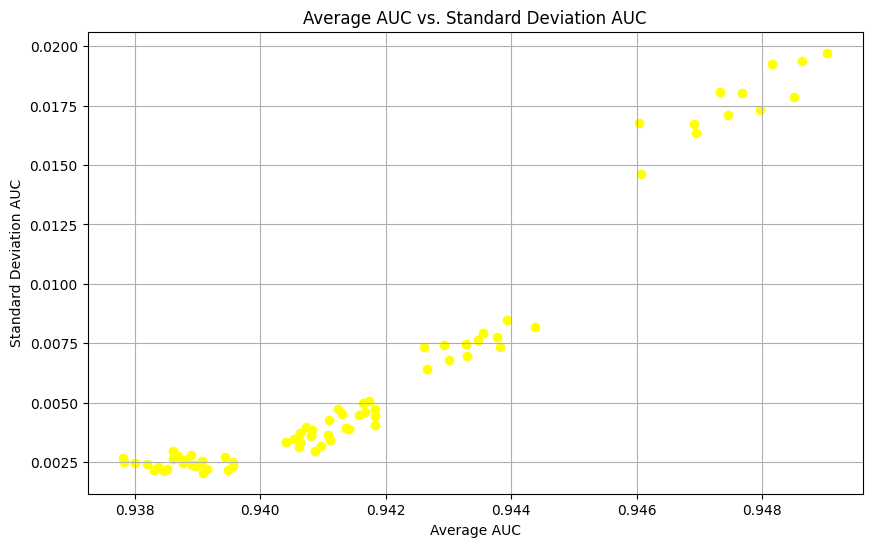

In [42]:
## Calculate average and standard deviation of AUC across three samples (train and two tests)
Grid_Search_Results['Average AUC'] = Grid_Search_Results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1)
Grid_Search_Results['Standard Deviation AUC'] = Grid_Search_Results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].std(axis=1)

## Create a scatter plot of average AUC and standard deviation AUC
plt.figure(figsize=(10, 6))
plt.scatter(Grid_Search_Results['Average AUC'], Grid_Search_Results['Standard Deviation AUC'], color='yellow')
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation AUC')
plt.title('Average AUC vs. Standard Deviation AUC')
plt.grid(True)
plt.show()








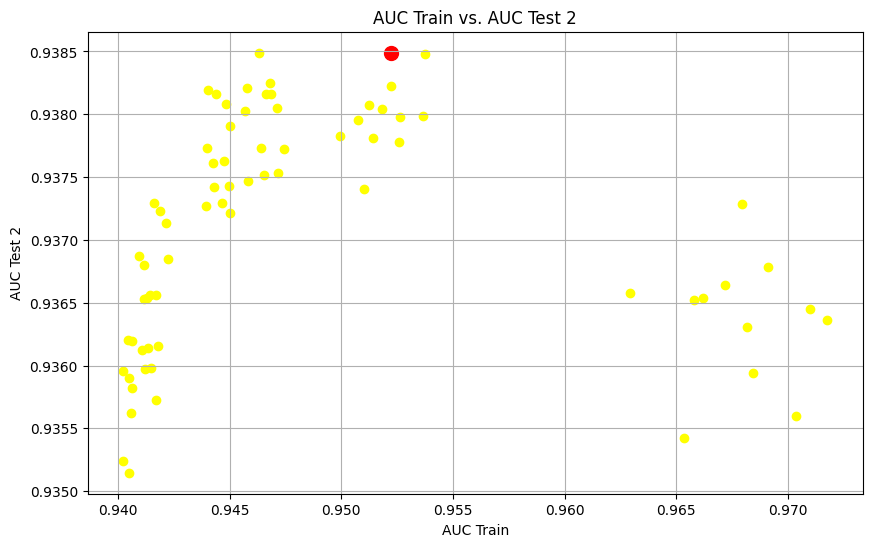

In [43]:
# X-Axis is AUC of train sample and Y-Axis is AUC of Test 2 sample
plt.figure(figsize=(10, 6))
plt.scatter(Grid_Search_Results['AUC Train'], Grid_Search_Results['AUC Test 2'], color='yellow')

# Find
highest_index = Grid_Search_Results['AUC Test 2'].idxmax()
plt.scatter(Grid_Search_Results.loc[highest_index, 'AUC Train'], Grid_Search_Results.loc[highest_index, 'AUC Test 2'], color='red', s=100, label='Highest AUC Test 2')
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('AUC Train vs. AUC Test 2')
plt.grid(True)
plt.show()

In [44]:
Grid_Search_Results

,Unnamed: 0,Number of Trees,Learning Rate (LR),Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Standard Deviation AUC
0,0,50,0.01,0.5,0.5,1,0.940945,0.939429,0.936873,0.939082,0.002058
1,1,50,0.01,0.5,0.5,5,0.940470,0.938735,0.936200,0.938469,0.002148
2,2,50,0.01,0.5,0.5,10,0.940225,0.938744,0.935953,0.938307,0.002169
3,3,50,0.01,0.5,1.0,1,0.941312,0.938871,0.936538,0.938907,0.002387
4,4,50,0.01,0.5,1.0,5,0.940651,0.938102,0.935825,0.938193,0.002414
...,...,...,...,...,...,...,...,...,...,...,...
67,67,300,0.10,0.8,0.5,5,0.967963,0.938638,0.937282,0.947961,0.017335
68,68,300,0.10,0.8,0.5,10,0.966207,0.938023,0.936537,0.946922,0.016718
69,69,300,0.10,0.8,1.0,1,0.971767,0.939000,0.936359,0.949042,0.019725
70,70,300,0.10,0.8,1.0,5,0.971000,0.938454,0.936448,0.948634,0.019396


In [45]:
# Find the best parameters
best_parameters = Grid_Search_Results.iloc[Grid_Search_Results['Standard Deviation AUC'].idxmin()]
print(best_parameters)
best_model = xgb.XGBClassifier(
    n_estimators=int(best_parameters['Number of Trees']),
    learning_rate=best_parameters['Learning Rate (LR)'],
    subsample=best_parameters['Subsample'],
    colsample_bytree=best_parameters['% Features'],
    scale_pos_weight=best_parameters['Weight of Default']
)

Unnamed: 0                 0.000000
Number of Trees           50.000000
Learning Rate (LR)         0.010000
Subsample                  0.500000
% Features                 0.500000
Weight of Default          1.000000
AUC Train                  0.940945
AUC Test 1                 0.939429
AUC Test 2                 0.936873
Average AUC                0.939082
Standard Deviation AUC     0.002058
Name: 0, dtype: float64


In [46]:
print(best_parameters)
print(best_model)

Unnamed: 0                 0.000000
Number of Trees           50.000000
Learning Rate (LR)         0.010000
Subsample                  0.500000
% Features                 0.500000
Weight of Default          1.000000
AUC Train                  0.940945
AUC Test 1                 0.939429
AUC Test 2                 0.936873
Average AUC                0.939082
Standard Deviation AUC     0.002058
Name: 0, dtype: float64
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weigh

In [47]:
# Train the best model
best_xgb_model = xgb.XGBClassifier(
    n_estimators=int(best_parameters['Number of Trees']),
    learning_rate=best_parameters['Learning Rate (LR)'],
    subsample=best_parameters['Subsample'],
    colsample_bytree=best_parameters['% Features'],
    scale_pos_weight=best_parameters['Weight of Default']
)

best_xgb_model.fit(X_train, y_train)

# Save the best model
best_xgb_model.save_model('best_xgb_model.json')

In [48]:
# Load the model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('best_xgb_model.json')

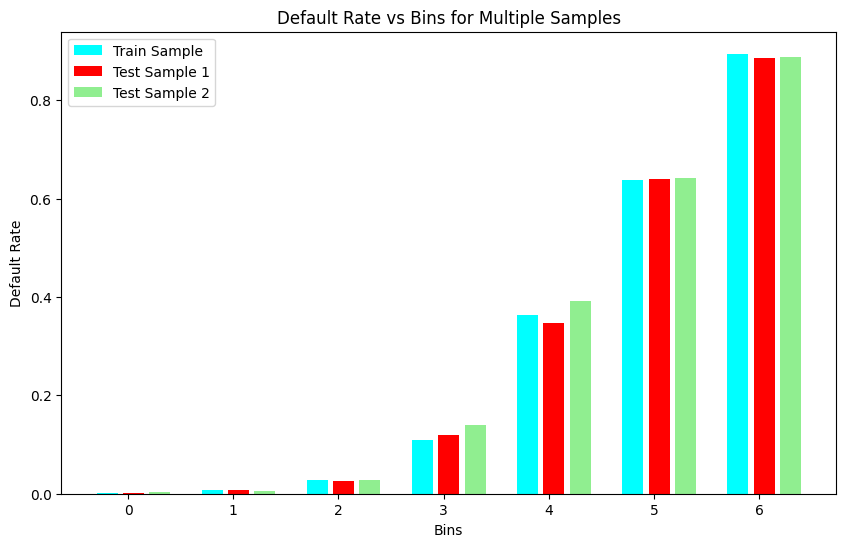

AUC on Train Sample: 0.9409445766850661
AUC on Test Sample 1: 0.9394291425091008
AUC on Test Sample 2: 0.9368727814098896


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def calculate_auc(model, X, y):
    """Calculate AUC for the given model and data."""
    return roc_auc_score(y, model.predict_proba(X)[:, 1])

def create_score_bins(model, X, q=9):
    """Create score bins for the given model and data."""
    return pd.qcut(model.predict_proba(X)[:, 1], q=q, labels=False, duplicates='drop')

def calculate_default_rate(bins, y):
    """Calculate default rate for each bin."""
    return [y[bins == i].mean() for i in range(bins.max() + 1)]

def plot_rank_ordering(train_default_rate, test1_default_rate, test2_default_rate, bin_labels=None):
    """Plot rank ordering of default rates for multiple samples."""
    plt.figure(figsize=(10, 6))
    
    # Convert default rates to numpy arrays
    train_default_rate = np.array(train_default_rate)
    test1_default_rate = np.array(test1_default_rate)
    test2_default_rate = np.array(test2_default_rate)
    
    # Check if all default rate arrays have the same length
    if len(train_default_rate) != len(test1_default_rate) or len(train_default_rate) != len(test2_default_rate):
        raise ValueError("All default rate arrays must have the same length.")
    
    # Set bin labels or default to range
    if bin_labels is None:
        bin_labels = np.arange(len(train_default_rate))  # Default bin labels if not provided
    
    # Ensure bin_labels matches the length of the default rates
    if len(bin_labels) != len(train_default_rate):
        raise ValueError("Bin labels must have the same length as the default rate arrays.")
    
    # Index for bar chart
    index = np.arange(len(bin_labels))
    bar_width = 0.2
    gap = 0.05
    
    # Plot the bar chart for each sample
    plt.bar(index, train_default_rate, bar_width, color='cyan', label='Train Sample')
    plt.bar(index + bar_width + gap, test1_default_rate, bar_width, color='red', label='Test Sample 1')
    plt.bar(index + 2 * (bar_width + gap), test2_default_rate, bar_width, color='lightgreen', label='Test Sample 2')
    
    # Add labels and title
    plt.xlabel('Bins')
    plt.ylabel('Default Rate')
    plt.title('Default Rate vs Bins for Multiple Samples')
    
    # Show bin labels on x-axis
    plt.xticks(index + bar_width, bin_labels)
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

# Calculate AUC for each sample
train_auc = calculate_auc(loaded_model, X_train, y_train)
test1_auc = calculate_auc(loaded_model, X_test1, y_test1)
test2_auc = calculate_auc(loaded_model, X_test2, y_test2)

# Create score bins for the train sample
train_bins = create_score_bins(loaded_model, X_train, q=8)

# Apply the same thresholds to test samples
test1_bins = create_score_bins(loaded_model, X_test1, q=8)
test2_bins = create_score_bins(loaded_model, X_test2, q=8)

# Calculate default rate in each bin for each sample
train_default_rate = calculate_default_rate(train_bins, y_train)
test1_default_rate = calculate_default_rate(test1_bins, y_test1)
test2_default_rate = calculate_default_rate(test2_bins, y_test2)

train_default_rate = np.array(train_default_rate)
test1_default_rate = np.array(test1_default_rate)
test2_default_rate = np.array(test2_default_rate)

train_default_rate = np.nan_to_num(train_default_rate, nan=0)
test1_default_rate = np.nan_to_num(test1_default_rate, nan=0)
test2_default_rate = np.nan_to_num(test2_default_rate, nan=0)

train_default_rate = train_default_rate.tolist()
train_default_rate = [item for sublist in train_default_rate for item in sublist]
test1_default_rate = test1_default_rate.tolist()
test1_default_rate = [item for sublist in test1_default_rate for item in sublist]
test2_default_rate = test2_default_rate.tolist()
test2_default_rate = [item for sublist in test2_default_rate for item in sublist]

bin_labels = ['0', '1', '2', '3', '4', '5', '6']

# Plot the rank orderings in a bar chart
plot_rank_ordering(train_default_rate, test1_default_rate, test2_default_rate, bin_labels)

# Display AUC of the model on each sample
print("AUC on Train Sample:", train_auc)
print("AUC on Test Sample 1:", test1_auc)
print("AUC on Test Sample 2:", test2_auc)

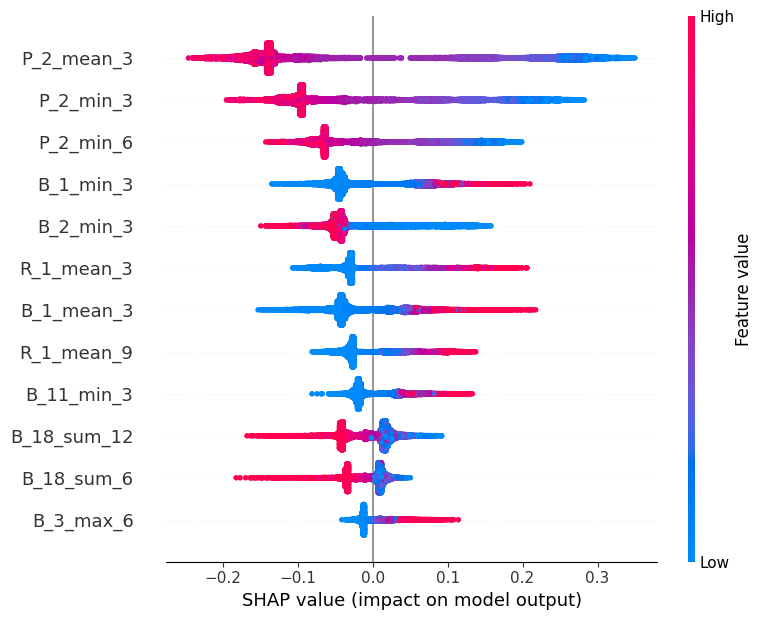

In [50]:

import shap
# # Load the test 2 data
# X_test2 = pd.read_csv('data/X_test2.csv')
# Initialize the TreeExplainer with the final XGBoost model
explainer = shap.Explainer(loaded_model)
# Calculate SHAP values for the Test 2 sample
shap_values = explainer.shap_values(X_test2)
# Create the beeswarm plot for the SHAP values
shap.summary_plot(shap_values, X_test2, plot_type="dot")

# Show the plot
plt.show()


In [51]:
import shap

# 1. Get SHAP values
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(X_train)  # Assuming X_train is the training data

# 2. Identify top 5 features
top_features_idx = np.argsort(-np.abs(shap_values.mean(0)))[:5]
top_features = [X_train.columns[i] for i in top_features_idx]

# 3. Calculate summary statistics for top 5 features
summary_stats = pd.DataFrame(columns=["Feature", "Min", "1st Percentile", "5th Percentile", "Median", "95th Percentile", "99th Percentile", "Max", "Mean", "% Missing"])

for feature in top_features:
    feature_values = X_train[feature]
    summary_stats.loc[len(summary_stats)] = [
        feature,
        feature_values.min(),
        np.percentile(feature_values, 1),
        np.percentile(feature_values, 5),
        feature_values.median(),
        np.percentile(feature_values, 95),
        np.percentile(feature_values, 99),
        feature_values.max(),
        feature_values.mean(),
        (feature_values.isnull().sum() / len(feature_values)) * 100
    ]

# 4. Create table
#summary_stats.to_excel("top_features_summary_statistics.xlsx", index=False)
print(summary_stats)

      Feature           Min  1st Percentile  5th Percentile    Median  \
0   B_2_min_3  5.485064e-08             NaN             NaN  0.810583   
1  R_1_mean_3  6.440720e-07        0.001364        0.002377  0.005686   
2  P_2_mean_3 -3.745006e-01             NaN             NaN  0.682820   
3  B_1_mean_3 -2.441467e-01        0.002226        0.003950  0.035982   
4   P_2_min_3 -4.205811e-01             NaN             NaN  0.659588   

   95th Percentile  99th Percentile       Max      Mean  % Missing  
0              NaN              NaN  1.009981  0.529722   0.006226  
1         0.588101         1.169727  2.175090  0.098493   0.000000  
2              NaN              NaN  1.009947  0.638800   0.611692  
3         0.646200         1.050152  1.323839  0.136794   0.000000  
4              NaN              NaN  1.009947  0.614300   0.611692  


In [52]:
explainer = shap.Explainer(loaded_model,X_test2)
shap_values = explainer(X_test2)

 98%|===================| 13517/13768 [00:51<00:00]        

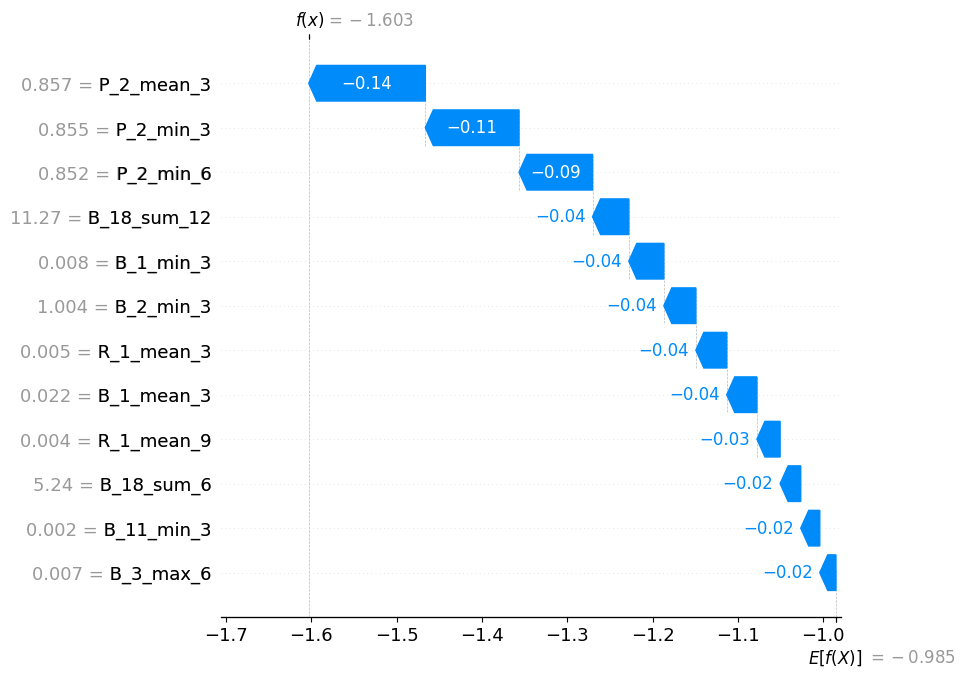

In [53]:
shap.plots.waterfall(shap_values[10], max_display=20)

In [54]:
# step 10: Neural Network
# Data Preprocessing
outliers = pd.DataFrame(columns = ['Feature', 'p1', 'p99'])

counter = 1
for col in X_train.columns:
    p1 = X_train[col].quantile(0.01)
    p99 = X_train[col].quantile(0.99)
    outliers.loc[counter] = [col, p1, p99]
    counter += 1
    print('complete iteration:', counter)
print('----Calculation Complete----')
outliers.to_csv('outliers.csv', index=False)



complete iteration: 2
complete iteration: 3
complete iteration: 4
complete iteration: 5
complete iteration: 6
complete iteration: 7
complete iteration: 8
complete iteration: 9
complete iteration: 10
complete iteration: 11
complete iteration: 12
complete iteration: 13
----Calculation Complete----


In [55]:
# replace outliers with p1 and p99
X_train = X_train.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)
X_test1 = X_test1.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)
X_test2 = X_test2.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)

In [56]:
# feature scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test1_scaled = pd.DataFrame(scaler.transform(X_test1), columns = X_train.columns)
X_test2_scaled = pd.DataFrame(scaler.transform(X_test2), columns = X_train.columns)


In [57]:
# fill missing values with 0
print('Number of missing values in X_train:', X_train_scaled.isnull().sum().sum())
print('Number of missing values in X_test1:', X_test1_scaled.isnull().sum().sum())
print('Number of missing values in X_test2:', X_test2_scaled.isnull().sum().sum())


Number of missing values in X_train: 1167
Number of missing values in X_test1: 265
Number of missing values in X_test2: 273


In [58]:
X_train_scaled.fillna(0, inplace=True)
X_test1_scaled.fillna(0, inplace=True)
X_test2_scaled.fillna(0, inplace=True)

In [59]:
# Check the number of missing values again
print('Number of missing values in X_train:', X_train_scaled.isnull().sum().sum())
print('Number of missing values in X_test1:', X_test1_scaled.isnull().sum().sum())
print('Number of missing values in X_test2:', X_test2_scaled.isnull().sum().sum())

Number of missing values in X_train: 0
Number of missing values in X_test1: 0
Number of missing values in X_test2: 0


In [60]:
X_train_scaled

,P_2_mean_3,P_2_min_3,B_18_sum_6,B_11_min_3,R_1_mean_9,R_1_mean_3,B_3_max_6,P_2_min_6,B_1_min_3,B_1_mean_3,B_18_sum_12,B_2_min_3
0,-0.100086,-0.650809,-0.961643,-0.154200,0.704492,-0.410863,0.670349,-0.601139,-0.070301,-0.150938,-0.811811,-1.172024
1,-0.746734,-0.655672,-1.027345,1.198938,-0.468877,-0.406592,1.541779,-0.587563,1.321831,1.238736,-0.774957,-1.214813
2,-1.718166,-1.643313,-1.589358,0.374681,2.028374,1.492090,2.073455,-1.673876,0.491907,0.393126,-1.597462,-1.216151
3,0.059923,0.124724,0.857003,-0.502704,-0.476748,-0.422977,-0.631195,0.038722,-0.552944,-0.595677,1.104496,0.685589
4,-0.269794,-0.178081,0.316040,-0.509591,-0.477803,-0.428528,-0.630438,-0.256199,-0.563172,-0.606298,0.311416,0.676677
...,...,...,...,...,...,...,...,...,...,...,...,...
64243,1.003705,0.880030,0.410571,-0.498854,-0.479235,-0.421076,-0.631055,0.943444,-0.561018,-0.602401,0.790492,0.681646
64244,0.497109,0.540434,-0.724874,-0.181660,-0.482273,-0.426669,0.920458,0.213803,-0.065095,-0.153812,-0.814568,-1.184948
64245,0.000000,0.000000,0.931196,-0.499780,-0.482740,-0.424694,-0.640240,0.000000,-0.485862,-0.520850,1.142722,-1.265988
64246,-0.196194,-0.165413,1.101203,-0.510634,-0.479838,-0.418504,-0.613969,-0.098803,-0.539091,-0.592630,-0.229418,1.136758


In [61]:
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_test1_scaled.to_csv('X_test1_scaled.csv', index=False)
X_test2_scaled.to_csv('X_test2_scaled.csv', index=False)

In [62]:
# load data for nn
X_train_scaled = pd.read_csv('X_train_scaled.csv')
X_test1_scaled = pd.read_csv('X_test1_scaled.csv')
X_test2_scaled = pd.read_csv('X_test2_scaled.csv')

y_train = pd.read_csv('y_train.csv')
y_test1 = pd.read_csv('y_test1.csv')
y_test2 = pd.read_csv('y_test2.csv')

In [63]:
# build neural network
nn_grid_search_result = pd.DataFrame(columns = ["#HL", "#Nodes", "ActivationFunction", "Dropout", "BatchSize", "AUC_Train", "AUC_Test1", "AUC_Test2"])

Counter = 0
for hl in [2,4]:
    for nodes in [4,6]:
        for activate_function in ["relu", "tanh"]:
            for dropout in [0, 0.5]:
                for batch_size in [100, 10000]:
                    model = Sequential()
                    model.add(Dense(nodes, input_dim=X_train_scaled.shape[1], activation=activate_function))
                    model.add(Dropout(dropout))
                    for i in range(hl - 1):
                        model.add(Dense(nodes, activation=activate_function))
                        model.add(Dropout(dropout))
                    model.add(Dense(1, activation='sigmoid'))
                    model.compile(optimizer=Adam(), loss=BinaryCrossentropy())
                    model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=20)
                    
                    nn_grid_search_result.loc[Counter, "#HL"] = hl
                    nn_grid_search_result.loc[Counter, "#Nodes"] = nodes
                    nn_grid_search_result.loc[Counter, "ActivationFunction"] = activate_function
                    nn_grid_search_result.loc[Counter, "Dropout"] = dropout
                    nn_grid_search_result.loc[Counter, "BatchSize"] = batch_size
                    nn_grid_search_result.loc[Counter, "AUC_Train"] = roc_auc_score(y_train, model.predict(X_train_scaled))
                    nn_grid_search_result.loc[Counter, "AUC_Test1"] = roc_auc_score(y_test1, model.predict(X_test1_scaled))
                    nn_grid_search_result.loc[Counter, "AUC_Test2"] = roc_auc_score(y_test2, model.predict(X_test2_scaled))
                    
                    Counter += 1

print('Grid search completed')
nn_grid_search_result.to_csv('nn_grid_search_result.csv')
                    
                    

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5475
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2918
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2810
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2811
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2832
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2803
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2781
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2766
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2798
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2776
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2730
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2758
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2777
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2799
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5594
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5409 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5220 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5089 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4928 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4801 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4698 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4567
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4491
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4384 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4294
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4217 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4163
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4110
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4034
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5339
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4209
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4086
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4041
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4071
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4040
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3992
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3972
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3997
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3978
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4001
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3978
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3976
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3964
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3985


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7670
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7440 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7274 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7153 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7006 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6834 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6709 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6588 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6502 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6377 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6314 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6191 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6109 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6048 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5989 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4110
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2927
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2871
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2859
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2807
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2823
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2810
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2789
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2836
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2799
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2752
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2761
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2763
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2764
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2791


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6840  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6600 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6373 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6164 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5975 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5813 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5666 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5522 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5400 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5285 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5172 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5084
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5001 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4902 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4832 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5432
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3987
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3789
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3647
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3645
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3669
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3644
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3567
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3577
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3592
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3569
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3574
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3564
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3602
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3620


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9167
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8896 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8611 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8305 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8018 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7757 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7504 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7332 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7120 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6966 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6824 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6668 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6511 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6392 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6279 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3750
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2847
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2777
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2776
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2774
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2734
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2757
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2736
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2765
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2744
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2764
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2778
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2742
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2753
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2756


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7574
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7052 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6529 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6049
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5622
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5245
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4940
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4674 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4449
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4244 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4057 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3914 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3791 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3689 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3600
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6022
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4044
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3870
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3815
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3772
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3791
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3703
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3694
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3698
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3719
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3703
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3672
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3711
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3705
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3767


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8143 
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7866 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7668 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7453 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7318 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7103 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7029 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6906 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6739 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6644 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6534 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6443 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6351 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6268 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6197 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4128
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2866
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2880
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2803
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2804
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2838
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2742
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2736
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2746
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2738
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2790
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2787
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2769
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2750
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2739


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6440
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5984 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5586 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5257 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5003 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4799 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4668 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4503 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4386 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4272 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4227
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4160 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4055 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4036 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3982 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5201
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3579
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3473
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3416
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3399
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3316
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3327
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3302
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3351
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3331
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3300
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3305
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3311
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3373
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3325


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7114
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6723 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6334 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6067
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5871
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5649 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5475  
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5382 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5274 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5171 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5072 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4984 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4906 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4827 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4764
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4541
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3154
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2994
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2962
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2883
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2867
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2825
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2837
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2836
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2810
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2793
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2792
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2813
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2796
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2778


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7003
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6923 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6869 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6832
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6802 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6770
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6736 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6702 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6668 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6631 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6589 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6549 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6505 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6462 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6411 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6374
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5612
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5468
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5350
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5172
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5055
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5015
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5046
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4993
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4925
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4908
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4885
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4902
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4851
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4861


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7727
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7454 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7099 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6884 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6625 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6460 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6385 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6218 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6155 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6014 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5933 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5894 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5818 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5778 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5735 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4426
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2948
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2862
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2816
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2811
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2805
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2760
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2805
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2759
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2790
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2794
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2755
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2739
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2771
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2757


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7975
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7712 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7460 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7222 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6998 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6807 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6629 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6478 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6341 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6211 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6084 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5962 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5838 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5691 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5557 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5953
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4579
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4243
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4096
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4053
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4011
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3959
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4010
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3970
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4030
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3974
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3953
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3955
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3975
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3986


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.7048
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6937
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6831 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6741 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6653 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6587 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6473 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6406 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6315 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6286 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6173 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6117 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6047 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5973 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5914 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3939
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2804
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2814
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2776
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2759
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2754
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2781
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2793
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2778
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2748
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2739
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2775
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2760
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2744
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2774


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6384 
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6156
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5933 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5719 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5496
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5275 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5056 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4836
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4636 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4443 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4254 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4048 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3884 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3722 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3603 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6497
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4984
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4575
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4455
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4426
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4366
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4332
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4292
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4292
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4299
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4264
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4292
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4272
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4233
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4279


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7272
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7121 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7020 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6922 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6801 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6701 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6614 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6494 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6402 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6343 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6251 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6175 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6080 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6002 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5942 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4023
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2891
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2831
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2837
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2779
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2795
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2770
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2768
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2771
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2772
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2794
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2809
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2791
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2757
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2738


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6125
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5715  
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5337 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5023 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4750 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4531 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4325 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4151 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4026 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3896 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3768 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3695 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3618 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3537 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3490 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5722
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4180
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3908
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3787
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3673
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3655
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3605
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3589
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3567
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3623
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3568
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3629
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3564
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3542
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3548


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6959
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6801 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6669 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6546 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6439 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6317
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6176 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6074 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5967
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5826 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5718 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5619 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5523 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5414 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5319 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/s

In [64]:
nn_grid_search_result = pd.read_csv('nn_grid_search_result.csv', index_col=0)
nn_grid_search_result

,#HL,#Nodes,ActivationFunction,Dropout,BatchSize,AUC_Train,AUC_Test1,AUC_Test2
0,2,4,relu,0.0,100,0.936367,0.938308,0.935881
1,2,4,relu,0.0,10000,0.890092,0.892822,0.889502
2,2,4,relu,0.5,100,0.914641,0.915972,0.911133
3,2,4,relu,0.5,10000,0.889659,0.888714,0.887702
4,2,4,tanh,0.0,100,0.936473,0.938232,0.935863
5,2,4,tanh,0.0,10000,0.890054,0.892995,0.888601
6,2,4,tanh,0.5,100,0.933813,0.936421,0.932320
7,2,4,tanh,0.5,10000,0.841537,0.841113,0.841095
8,2,6,relu,0.0,100,0.936940,0.938870,0.936011
9,2,6,relu,0.0,10000,0.913802,0.916841,0.913078


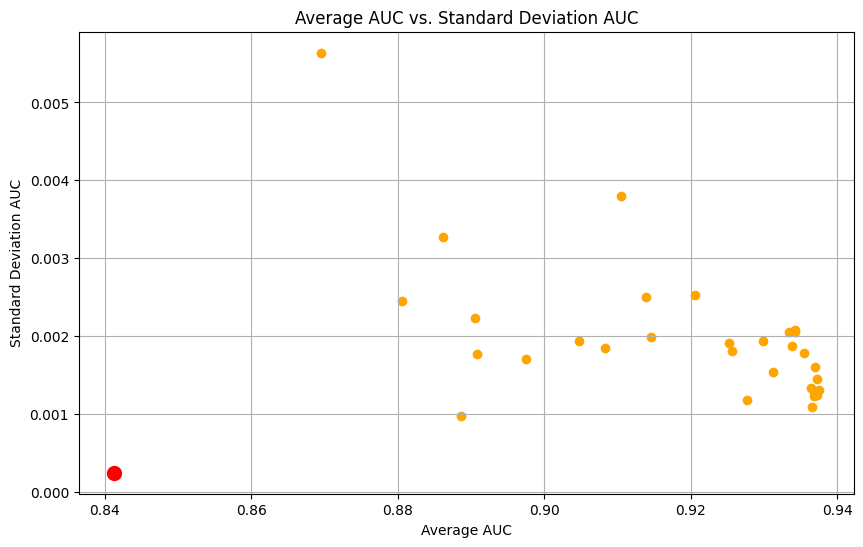

In [65]:
# Create a new column for the average AUC across all three samples and standard deviation of AUC across all three samples
nn_grid_search_result['Average AUC'] = nn_grid_search_result[['AUC_Train', 'AUC_Test1', 'AUC_Test2']].mean(axis=1)
nn_grid_search_result['Standard Deviation AUC'] = nn_grid_search_result[['AUC_Train', 'AUC_Test1', 'AUC_Test2']].std(axis=1)

# Create a scatter plot of average AUC and standard deviation AUC
plt.figure(figsize=(10, 6))
plt.scatter(nn_grid_search_result['Average AUC'], nn_grid_search_result['Standard Deviation AUC'], color='orange')
# Highlight the lowest standard deviation AUC
lowest_std_auc_index = nn_grid_search_result['Standard Deviation AUC'].idxmin()
plt.scatter(nn_grid_search_result.loc[lowest_std_auc_index, 'Average AUC'], nn_grid_search_result.loc[lowest_std_auc_index, 'Standard Deviation AUC'], color='red', s=100, label='Lowest Standard Deviation AUC')
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation AUC')
plt.title('Average AUC vs. Standard Deviation AUC')
plt.grid(True)
plt.show()

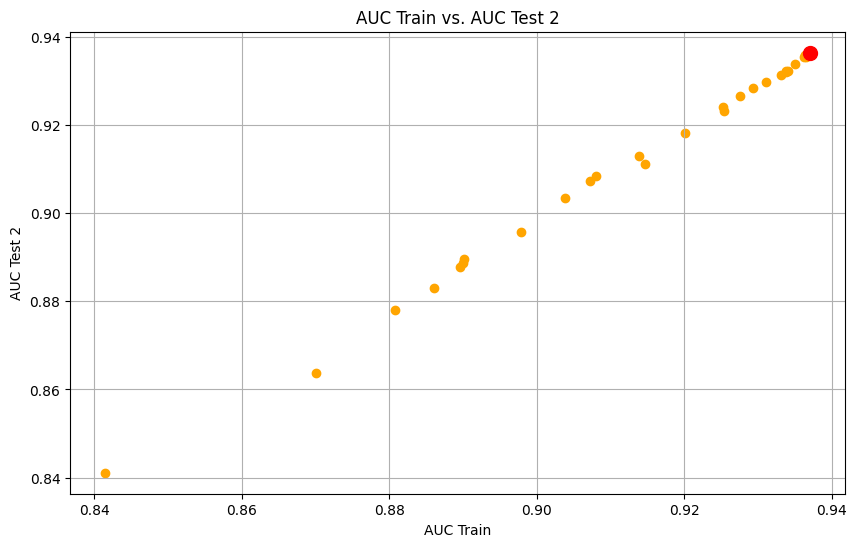

In [66]:
# Create a scatter plot of AUC Train and AUC Test 2
plt.figure(figsize=(10, 6))
plt.scatter(nn_grid_search_result['AUC_Train'], nn_grid_search_result['AUC_Test2'], color='orange')
# Highlight the highest AUC Test 2
highest_auc_test2_index = nn_grid_search_result['AUC_Test2'].idxmax()
plt.scatter(nn_grid_search_result.loc[highest_auc_test2_index, 'AUC_Train'], nn_grid_search_result.loc[highest_auc_test2_index, 'AUC_Test2'], color='red', s=100, label='Highest AUC Test 2')
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('AUC Train vs. AUC Test 2')
plt.grid(True)
plt.show()

In [67]:
nn_grid_search_result

,#HL,#Nodes,ActivationFunction,Dropout,BatchSize,AUC_Train,AUC_Test1,AUC_Test2,Average AUC,Standard Deviation AUC
0,2,4,relu,0.0,100,0.936367,0.938308,0.935881,0.936852,0.001284
1,2,4,relu,0.0,10000,0.890092,0.892822,0.889502,0.890805,0.001771
2,2,4,relu,0.5,100,0.914641,0.915972,0.911133,0.913915,0.002500
3,2,4,relu,0.5,10000,0.889659,0.888714,0.887702,0.888692,0.000979
4,2,4,tanh,0.0,100,0.936473,0.938232,0.935863,0.936856,0.001230
5,2,4,tanh,0.0,10000,0.890054,0.892995,0.888601,0.890550,0.002238
6,2,4,tanh,0.5,100,0.933813,0.936421,0.932320,0.934184,0.002076
7,2,4,tanh,0.5,10000,0.841537,0.841113,0.841095,0.841248,0.000250
8,2,6,relu,0.0,100,0.936940,0.938870,0.936011,0.937274,0.001458
9,2,6,relu,0.0,10000,0.913802,0.916841,0.913078,0.914574,0.001997


In [68]:
# STEP 13: Find the best parameters for NN
X_train_scaled = pd.read_csv('X_train_scaled.csv')
y_train = pd.read_csv('y_train.csv')
X_test1_scaled = pd.read_csv('X_test1_scaled.csv')
y_test1 = pd.read_csv('y_test1.csv')
X_test2_scaled = pd.read_csv('X_test2_scaled.csv')
y_test2 = pd.read_csv('y_test2.csv')

In [69]:
nn_grid_search_result.iloc[20]

#HL                              4
#Nodes                           4
ActivationFunction            tanh
Dropout                        0.0
BatchSize                      100
AUC_Train                 0.936537
AUC_Test1                 0.937724
AUC_Test2                 0.935537
Average AUC               0.936599
Standard Deviation AUC    0.001095
Name: 20, dtype: object

In [70]:
# Find the best parameters from row 20
best_parameters_nn = nn_grid_search_result.iloc[20]
best_model_nn = Sequential()
best_model_nn.add(Dense(int(best_parameters_nn['#Nodes']), input_dim=X_train_scaled.shape[1], activation=best_parameters_nn['ActivationFunction']))
best_model_nn.add(Dropout(best_parameters_nn['Dropout']))
for i in range(int(best_parameters_nn['#HL']) - 1):
    best_model_nn.add(Dense(int(best_parameters_nn['#Nodes']), activation=best_parameters_nn['ActivationFunction']))
    best_model_nn.add(Dropout(best_parameters_nn['Dropout']))
best_model_nn.add(Dense(1, activation='sigmoid'))
best_model_nn.compile(optimizer=Adam(), loss=BinaryCrossentropy())
best_model_nn.fit(X_train_scaled, y_train, batch_size=int(best_parameters_nn['BatchSize']), epochs=20)

Epoch 1/20


c:\PYTHON\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3885
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2964
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2918
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2817
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2825
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2814
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2791
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2808
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2795
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2771
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2806
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2767
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2731
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2749
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2774


In [71]:
# Save the best model
best_model_nn.save('best_model_nn.keras')

In [72]:
from tensorflow.keras.models import load_model
best_model_nn = load_model("best_model_nn.keras")

2008/2008 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


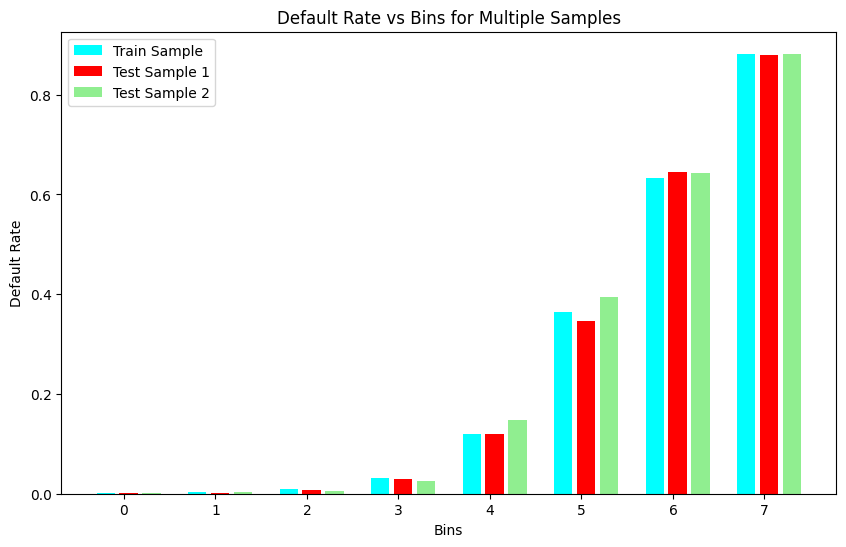

2008/2008 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
AUC on Train Sample: 0.9367236384292172
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC on Test Sample 1: 0.9385389345955584
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC on Test Sample 2: 0.9360935197838053


In [73]:
# create bin based on best_model_nn result on train, test1, and test2
import pandas as pd
import numpy as np
from keras.models import load_model

# Load the NN model
nn_model = load_model('best_model_nn.keras')

# Function to create score bins
def create_score_bins_nn(model, X, q=9):
    """Create score bins for the given NN model and data."""
    scores = model.predict(X).flatten()  # Ensure the scores are 1-dimensional
    return pd.qcut(scores, q=q, labels=False, duplicates='drop')

# Example usage
# Assuming `X_train_scaled`, `X_test1_scaled`, and `X_test2_scaled` are your input data
train_bins_nn = create_score_bins_nn(nn_model, X_train_scaled, q=8)
test1_bins_nn = create_score_bins_nn(nn_model, X_test1_scaled, q=8)
test2_bins_nn = create_score_bins_nn(nn_model, X_test2_scaled, q=8)

# Calculate default rate in each bin for each sample
train_default_rate_nn = calculate_default_rate(train_bins_nn, y_train)
test1_default_rate_nn = calculate_default_rate(test1_bins_nn, y_test1)
test2_default_rate_nn = calculate_default_rate(test2_bins_nn, y_test2)

train_default_rate_nn = np.array(train_default_rate_nn)
test1_default_rate_nn = np.array(test1_default_rate_nn)
test2_default_rate_nn = np.array(test2_default_rate_nn)

train_default_rate_nn = np.nan_to_num(train_default_rate_nn, nan=0)
test1_default_rate_nn = np.nan_to_num(test1_default_rate_nn, nan=0)
test2_default_rate_nn = np.nan_to_num(test2_default_rate_nn, nan=0)

train_default_rate_nn = train_default_rate_nn.tolist()
train_default_rate_nn = [item for sublist in train_default_rate_nn for item in sublist]
test1_default_rate_nn = test1_default_rate_nn.tolist()
test1_default_rate_nn = [item for sublist in test1_default_rate_nn for item in sublist]
test2_default_rate_nn = test2_default_rate_nn.tolist()
test2_default_rate_nn = [item for sublist in test2_default_rate_nn for item in sublist]

# Plot the rank orderings in a bar chart
plot_rank_ordering(train_default_rate_nn, test1_default_rate_nn, test2_default_rate_nn)

# Display AUC of the model on each sample
print("AUC on Train Sample:", roc_auc_score(y_train, nn_model.predict(X_train_scaled)))
print("AUC on Test Sample 1:", roc_auc_score(y_test1, nn_model.predict(X_test1_scaled)))
print("AUC on Test Sample 2:", roc_auc_score(y_test2, nn_model.predict(X_test2_scaled)))




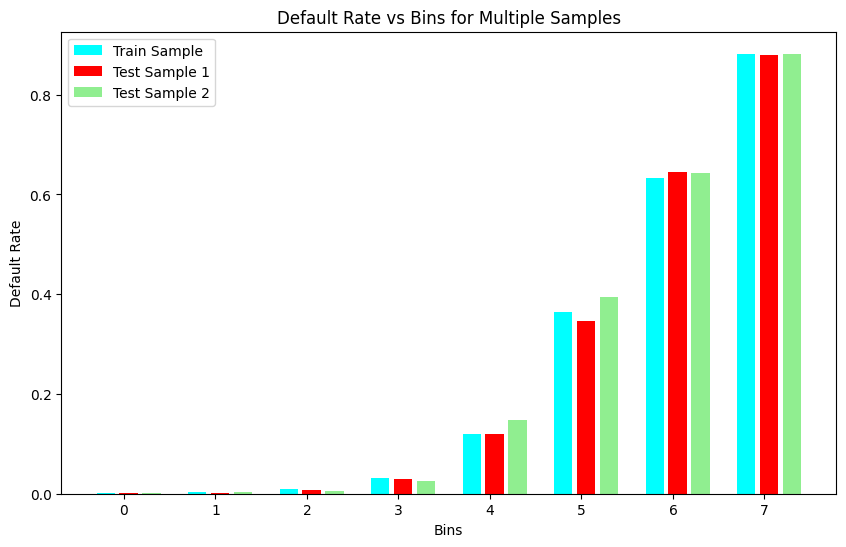

2008/2008 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
AUC on Train Sample: 0.9367236384292172
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC on Test Sample 1: 0.9385389345955584
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC on Test Sample 2: 0.9360935197838053


In [74]:
# Plot the rank orderings in a bar chart
plot_rank_ordering(train_default_rate_nn, test1_default_rate_nn, test2_default_rate_nn)

# Display AUC of the model on each sample
print("AUC on Train Sample:", roc_auc_score(y_train, nn_model.predict(X_train_scaled)))
print("AUC on Test Sample 1:", roc_auc_score(y_test1, nn_model.predict(X_test1_scaled)))
print("AUC on Test Sample 2:", roc_auc_score(y_test2, nn_model.predict(X_test2_scaled)))

**strategy part**
// strategy part

In [75]:
feature_importance_concat_df = pd.read_csv('feature_importance_concat.csv')

In [76]:
# Use B_5 and S_7 as balance and spend columns based on feature importance and SHAP analysis results
# Load original train data again
df_strategy = pd.read_csv('train_encoded_data.csv')
df_strategy = df_strategy[['customer_ID', 'S_2', 'B_18', 'S_7', 'target']]

In [77]:
df = pd.read_csv('df_feature_engineered_agg.csv', index_col=0)
label = pd.read_csv('train_labels.csv')
df_ = pd.merge(df, label, on='customer_ID', how='inner')

In [78]:
# Drop the target column
X = df_.drop(columns=['target'])
y = df_['target']

# Split the data into train and test sets
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X, y, test_size=0.3, random_state=42)
X_test1_st, X_test2_st, y_test1_st, y_test2_st = train_test_split(X_test_st, y_test_st, test_size=0.5, random_state=42)

# Ensure customer_ID is included in the selected features
selected_features = feature_importance_concat_df['Feature'].tolist() + ['customer_ID']

# Select the features along with customer_ID
X_train_st = X_train_st[selected_features]
X_test1_st = X_test1_st[selected_features]
X_test2_st = X_test2_st[selected_features]

In [79]:
import pandas as pd
import xgboost as xgb

# Load the best model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('best_xgb_model.json')

def apply_model_and_get_output(model, X, customer_id_col='customer_ID'):
    # Drop the customer_ID column for prediction
    X_ = X.drop(columns=[customer_id_col])
    
    # Apply the model to the data
    model_output = model.predict_proba(X_)[:, 1]
    
    # Create a DataFrame with customer_ID and model output
    model_output_df = pd.DataFrame({
        customer_id_col: X[customer_id_col],
        'model_output': model_output
    })
    
    return model_output_df

# Apply the function to X_train_st, X_test1_st, and X_test2_st
model_output_train = apply_model_and_get_output(loaded_model, X_train_st)
model_output_test1 = apply_model_and_get_output(loaded_model, X_test1_st)
model_output_test2 = apply_model_and_get_output(loaded_model, X_test2_st)

# Merge the model output with the original data
df_strategy_train = df_strategy.merge(model_output_train, on='customer_ID', how='inner')
df_strategy_test1 = df_strategy.merge(model_output_test1, on='customer_ID', how='inner')
df_strategy_test2 = df_strategy.merge(model_output_test2, on='customer_ID', how='inner')

# Display the head of the merged DataFrames
print(df_strategy_train.head())
print(df_strategy_test1.head())
print(df_strategy_test2.head())

                                         customer_ID         S_2      B_18  \
0  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-03-11  0.690226   
1  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-04-22  0.326655   
2  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-05-12  0.326533   
3  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-06-10  0.328837   
4  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-07-19  0.322515   

        S_7  target  model_output  
0  0.395565       0      0.324885  
1  0.370878       0      0.324885  
2  0.376603       0      0.324885  
3  0.374392       0      0.324885  
4  0.387431       0      0.324885  
                                         customer_ID         S_2      B_18  \
0  0007ee1ac8edb6be588c6c8a158d2268e3228c49cf5277...  2017-03-17  0.057585   
1  0007ee1ac8edb6be588c6c8a158d2268e3228c49cf5277...  2017-04-22  0.056978   
2  0007ee1ac8edb6be588c6c8a158d2268e3228c49cf5277...  2017-05-22  0.060074   
3  

In [80]:
df_strategy_train = df_strategy_train.fillna(0)
df_strategy_test1 = df_strategy_test1.fillna(0)
df_strategy_test2 = df_strategy_test2.fillna(0)

In [82]:
def calculate_average_values(df, start_month=11, end_month=4, start_year=2017, end_year=2018):
    # Convert 'S_2' column to datetime
    df['S_2'] = pd.to_datetime(df['S_2'])
    df['month'] = df['S_2'].dt.month
    df['year'] = df['S_2'].dt.year

    # Filter the data for the specified period
    data_nov_apr = df[(df['year'] == start_year) & (df['month'] >= start_month) | (df['year'] == end_year) & (df['month'] <= end_month)]

    # Calculate the average value of 'B_18' and 'S_7' for each customer
    average_values = data_nov_apr.groupby('customer_ID')[['B_18', 'S_7']].mean()

    # Merge the average values with the original data
    df_updated = average_values.merge(df, on='customer_ID', how='inner')
    grouped_df = df_updated.groupby('customer_ID')[['target', 'model_output', 'B_18_y', 'S_7_y']].mean()

    return grouped_df

# Example usage
df_strategy_train = calculate_average_values(df_strategy_train)
df_strategy_test1 = calculate_average_values(df_strategy_test1)
df_strategy_test2 = calculate_average_values(df_strategy_test2)

In [83]:
df_strategy_train

,target,model_output,B_18_y,S_7_y
customer_ID,,,,
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4,0.0,0.324885,0.349598,0.396955
000445609ff2a39d2dd02484899affa5696210a95f6869f26390bd26eeb3b651,0.0,0.167568,0.976674,0.089376
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff4b5b317ac251abda0,0.0,0.288422,0.189352,0.331525
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704029f989240c733b6d0,0.0,0.170712,0.956550,0.080779
00050d84c6d26e26cd2b18c3eed83d3130c270e2361470ff272f9409103d067f,0.0,0.167709,0.904478,0.018486
...,...,...,...,...
fff78e53cce577f5e00352979ba8c50463e44579f6438ff0a0e11b93520df9f4,0.0,0.257774,0.098951,0.114187
fffcfd4dcb5311e3b7022eeec6c194f0ee01528bb45a01bc6041836529700c14,0.0,0.172456,0.646428,0.147772
fffe2bc02423407e33a607660caeed076d713d8a5ad32321530e92704835da88,1.0,0.468713,0.362750,1.099377


In [88]:
def calculate_strategy_performance(data, target_col, model_output_col, balance_col, spend_col, threshold):
    # Split data into accepted and rejected based on the threshold
    accepted = data[data[model_output_col] < threshold]
    rejected = data[data[model_output_col] >= threshold]

    # Calculate portfolio default rate
    portfolio_default_rate = accepted[target_col].mean() if not accepted.empty else 0

    # Separate accepted defaulters and non-defaulters
    accepted_defaulters = accepted[accepted[target_col] == 1]
    accepted_non_defaulters = accepted[accepted[target_col] == 0]

    # Calculate revenue from non-defaulters
    if not accepted_non_defaulters.empty:
        non_defaulter_revenue = (accepted_non_defaulters[balance_col].mean() * 0.02 + 
                                 accepted_non_defaulters[spend_col].mean() * 0.001) * 12
    else:
        non_defaulter_revenue = 0

    # Calculate total portfolio revenue
    portfolio_revenue = non_defaulter_revenue * len(accepted_non_defaulters)

    # Calculate total accepted applicants
    total_accepted = len(accepted)

    return total_accepted, portfolio_default_rate, portfolio_revenue

def calculate_strategy_results(df_strategy_train, df_strategy_test1, df_strategy_test2, thresholds):
    strategy_results_train = pd.DataFrame(columns=['Threshold', 'accepted_Customers', 'Default Rate', 'Revenue'])
    strategy_results_test1 = pd.DataFrame(columns=['Threshold', 'accepted_Customers', 'Default Rate', 'Revenue'])
    strategy_results_test2 = pd.DataFrame(columns=['Threshold', 'accepted_Customers', 'Default Rate', 'Revenue'])

    for t in thresholds:
        strategy_results_train.loc[len(strategy_results_train)] = [t] + list(calculate_strategy_performance(df_strategy_train, 'target', 'model_output', 'B_18_y', 'S_7_y', t))
        strategy_results_test1.loc[len(strategy_results_test1)] = [t] + list(calculate_strategy_performance(df_strategy_test1, 'target', 'model_output', 'B_18_y', 'S_7_y', t))
        strategy_results_test2.loc[len(strategy_results_test2)] = [t] + list(calculate_strategy_performance(df_strategy_test2, 'target', 'model_output', 'B_18_y', 'S_7_y', t))

    strategy_results = strategy_results_train.merge(strategy_results_test1, on='Threshold', suffixes=('_train', '_test1',)).merge(strategy_results_test2, on='Threshold')
    return strategy_results

# Example usage
#thresholds = [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.95 ]
thresholds = [i / 100 for i in range(10, 100)]

strategy_results = calculate_strategy_results(df_strategy_train, df_strategy_test1, df_strategy_test2, thresholds)
strategy_results = strategy_results.fillna(0)
print(strategy_results)

    Threshold  accepted_Customers_train  Default Rate_train  Revenue_train  \
0        0.10                       0.0            0.000000       0.000000   
1        0.11                       0.0            0.000000       0.000000   
2        0.12                       0.0            0.000000       0.000000   
3        0.13                       0.0            0.000000       0.000000   
4        0.14                       0.0            0.000000       0.000000   
..        ...                       ...                 ...            ...   
85       0.95                   64248.0            0.255759    8092.174786   
86       0.96                   64248.0            0.255759    8092.174786   
87       0.97                   64248.0            0.255759    8092.174786   
88       0.98                   64248.0            0.255759    8092.174786   
89       0.99                   64248.0            0.255759    8092.174786   

    accepted_Customers_test1  Default Rate_test1  Revenue_test1

In [85]:
strategy_results.to_csv('strategy_results.csv', index=False)

In [86]:
strategy_results

,Threshold,accepted_Customers_train,Default Rate_train,Revenue_train,accepted_Customers_test1,Default Rate_test1,Revenue_test1,accepted_Customers,Default Rate,Revenue
0,0.10,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
1,0.11,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
2,0.12,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
3,0.13,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
4,0.14,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
85,0.95,64248.0,0.255759,8092.174786,13767.0,0.253795,1736.47888,13768.0,0.262711,1719.640882
86,0.96,64248.0,0.255759,8092.174786,13767.0,0.253795,1736.47888,13768.0,0.262711,1719.640882
87,0.97,64248.0,0.255759,8092.174786,13767.0,0.253795,1736.47888,13768.0,0.262711,1719.640882
88,0.98,64248.0,0.255759,8092.174786,13767.0,0.253795,1736.47888,13768.0,0.262711,1719.640882
